
# Project Setup and Execution Instructions

## Overview
This notebook requires access to a specific folder in Google Drive. Follow the steps below to set up the project:

## Project Setup
1. Add a shortcut of this folder: [Shared Folder Link](https://drive.google.com/drive/folders/1ySpjMA1MVeFCnnFrjvxei4QucpDnk27e?usp=sharing) to your Google Drive directory: `/content/drive/MyDrive/Colab Notebooks/`

Adding shortcut steps:
1.1. Open the shared folder link.
1.2. Right click on the DL_course folder -> Organize -> Add shorcut.
1.3. A popup with Add shortcut to DL_course title will appear. Choose Colab Notebooks folder.

2. Verify the folder addition by running the `checkDriveDir` function. If successful, you should see a list of folders, including `chest_xray` and `winning_architecture`, confirming that the DL_course shortcut was added to your drive.

3. Run Notebook Cells: Execute the notebook cells one by one to perform the test.


## Imports

In [ ]:
import copy
import os
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
from torchvision import datasets, models, transforms
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch.nn.functional as F
from google.colab import drive
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from matplotlib import pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
import random


## Hyperparameters


In [115]:

EPOCHS = 10
checkpoint_dir = "/content/drive/MyDrive/Colab Notebooks/DL_course"

data_dir = checkpoint_dir + "/chest_xray"

TEST = 'test'
TRAIN = 'train'
VAL ='val'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
visualization = True

from google.colab import drive
drive.mount('/content/drive')

print(device)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cpu


In [125]:
def checkDriveDir():
  folders = [folder for folder in os.listdir(checkpoint_dir) if os.path.isdir(os.path.join(checkpoint_dir, folder))]

  # Print the list of folders
  if folders:
      print("List of Folders:")
      for folder in folders:
          print(f" - {folder}")
  else:
      print("No folders found in the /content/drive/MyDrive/Colab Notebooks/DL_course.")
checkDriveDir()

List of Folders:
 - chest_xray
 - with_focal
 - winning architecture
 - Output_1b
 - with_focal_backup
 - logs


**Task 1a - Classification healthy/sick Xray Imaging  🍒**


---



# Task 1.a - Classification of healthy/sick

## Visualizations

In [85]:
def plot_confusion_matrix(labels, preds, class_names):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig(os.path.join(checkpoint_dir, 'confusion_matrix.png'))

    plt.show()
    plt.close()

## Model, Optimizer, Data Preprocessing




In [86]:
# Data Transformation & Augmentations
def data_transforms(phase):
    # If the phase is TRAIN
    if phase == TRAIN:
        # Compose transformations: Resize, CenterCrop, Convert to Tensor, Normalize
        transform = transforms.Compose([
            transforms.Resize(256),  # Resize the image to 256x256 pixels
            transforms.CenterCrop(224),  # Crop the center of the image to 224x224 pixels
            transforms.ToTensor(),  # Convert the image to a PyTorch Tensor
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),  # Normalize the Tensor
        ])

    # If the phase is VAL
    if phase == VAL:
        # Apply the same transformations as the TRAIN phase
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])

    # If the phase is TEST
    if phase == TEST:
        # Apply the same transformations as the TRAIN phase
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])

    return transform

## Prepere dataset and dataloader

In [87]:
# Prepere dataset and dataloader

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms(x))
                  for x in [TRAIN, VAL, TEST]}

dataloaders = {
    TRAIN: torch.utils.data.DataLoader(image_datasets[TRAIN], batch_size=32, shuffle=True),
    VAL: torch.utils.data.DataLoader(image_datasets[VAL], batch_size=1, shuffle=True),
    TEST: torch.utils.data.DataLoader(image_datasets[TEST], batch_size=1, shuffle=True)
}

dataset_sizes = {
    x: len(image_datasets[x])
    for x in [TRAIN, VAL]
}

classes = image_datasets[TRAIN].classes
class_names = image_datasets[TRAIN].classes

## Test


In [7]:
# Prepare Tesing loop
def test_model():
    # Initialize counters
    running_correct = 0.0
    running_total = 0.0
    true_labels = []
    pred_labels = []
    input_images = []
    all_preds = torch.tensor([])
    all_labels = torch.tensor([])

    # No need to track gradients for testing
    with torch.no_grad():
        # Iterate over test data
        for data in dataloaders[TEST]:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Store true labels
            true_labels.append(labels.item())

            # Store model input images
            input_images.append(inputs)

            # Forward pass
            outputs = model_pre(inputs)
            _, preds = torch.max(outputs.data, 1)
            all_preds = torch.cat((all_preds, preds.cpu()), dim=0)
            all_labels = torch.cat((all_labels, labels.cpu()), dim=0)

            # Store predicted labels
            pred_labels.append(preds.item())

            # Update counters
            running_total += labels.size(0)
            running_correct += (preds == labels).sum().item()

        # Calculate accuracy
        acc = running_correct / running_total

    return true_labels, pred_labels, input_images, running_correct, running_total, acc, all_labels, all_preds

## Test ResNet

In [23]:
# Load Winning Architecture
checkpoint_winning_ResNet = checkpoint_dir + "/winning architecture/epoch_7_winning_1a.pth"
model_pre = models.resnet18(pretrained=True)
model_pre = model_pre.to(device)
for param in model_pre.parameters():
    param.requires_grad = False

model_pre.fc = nn.Sequential(
    nn.Linear(512, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 2)).to(device)
checkpoint = torch.load(checkpoint_winning_ResNet, map_location=torch.device(device))
model_pre.load_state_dict(checkpoint)

model_pre.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [24]:
# Test
true_labels, pred_labels, input_images, running_correct, running_total, acc, all_labels, all_preds= test_model()


In [25]:
print("Test Accuracy: ", acc)


Test Accuracy:  0.8637820512820513


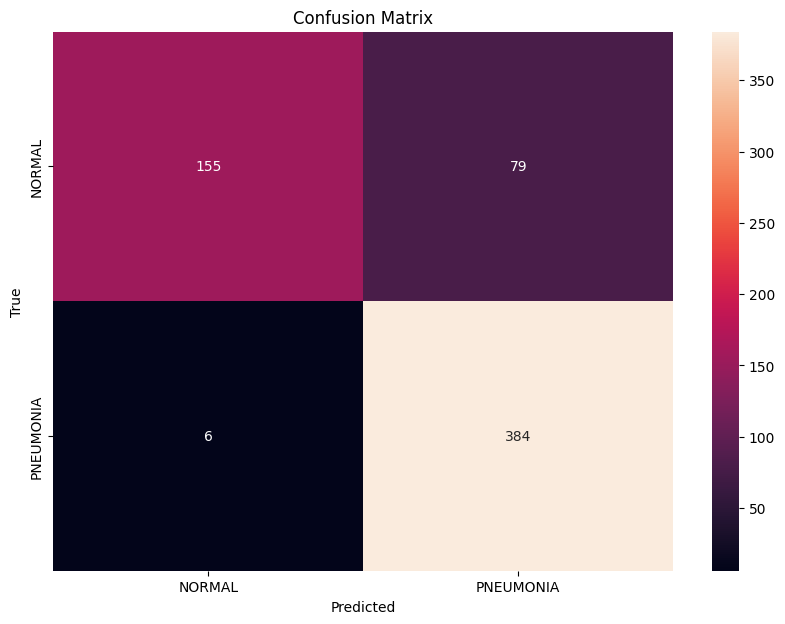

In [ ]:
# Eval test data with confusion Matrix
plot_confusion_matrix(all_labels, all_preds, class_names)

## Test AlexNet

In [ ]:
import torch
import torchvision.models as models
import torch.nn as nn

# Load AlexNet architecture
model_pre = models.alexnet(pretrained=True)

# Freeze all parameters in the feature extractor
for param in model_pre.parameters():
    param.requires_grad = False

# Modify the fully connected layers (classifier)
model_pre.classifier = nn.Sequential(
   nn.Linear(256 * 6 * 6, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 1024),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(1024, 2)  # Output layer for 2 classes (adjust based on your task)
)

# Load the checkpoint for AlexNet
checkpoint_winning_AlexNet = checkpoint_dir + "/winning architecture/AlexNet.pth"
checkpoint = torch.load(checkpoint_winning_AlexNet, map_location=torch.device(device))

model_pre.load_state_dict(checkpoint)

# Set the model to evaluation mode
model_pre.eval()
model_pre = model_pre.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
true_labels, pred_labels, input_images, running_correct, running_total, acc, all_labels, all_preds = test_model()

In [ ]:
print("Alex net test Accuracy: ", acc)


Alex net test Accuracy:  0.8493589743589743


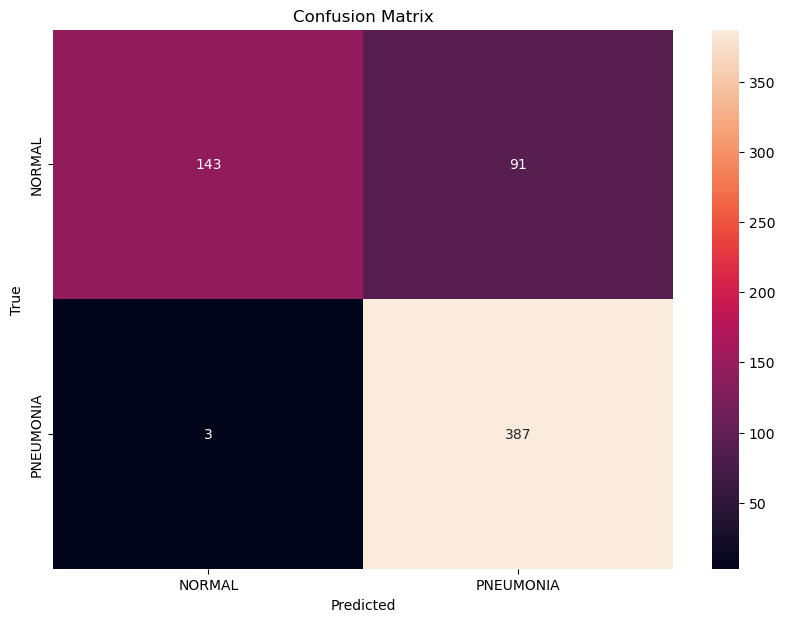

In [ ]:
# Eval test data with confusion Matrix
plot_confusion_matrix(all_labels, all_preds, class_names)

## Test VGG

In [ ]:
import torch
import torchvision.models as models
import torch.nn as nn
model_pre = models.vgg16(pretrained=True)

# Freeze the pre-trained parameters
for param in model_pre.parameters():
    param.requires_grad = False

# Replace the classifier (fully connected layers) with a custom one
num_features = model_pre.classifier[6].in_features
model_pre.classifier[6] = nn.Sequential(
    nn.Linear(num_features, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 1024),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(1024, 2)  # Output layer for 2 classes (adjust based on your task)
)

# Load the checkpoint for AlexNet
checkpoint_winning_VGG = checkpoint_dir + "/winning architecture/VGG16.pth"

checkpoint = torch.load(checkpoint_winning_VGG, map_location=torch.device(device))

model_pre.load_state_dict(checkpoint)

# Set the model to evaluation mode
model_pre.eval()
model_pre = model_pre.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 106MB/s]


In [ ]:
true_labels, pred_labels, input_images, running_correct, running_total, acc, all_labels, all_preds = test_model()

In [ ]:
print("VGG test Accuracy: ", acc)

VGG test Accuracy:  0.8012820512820513


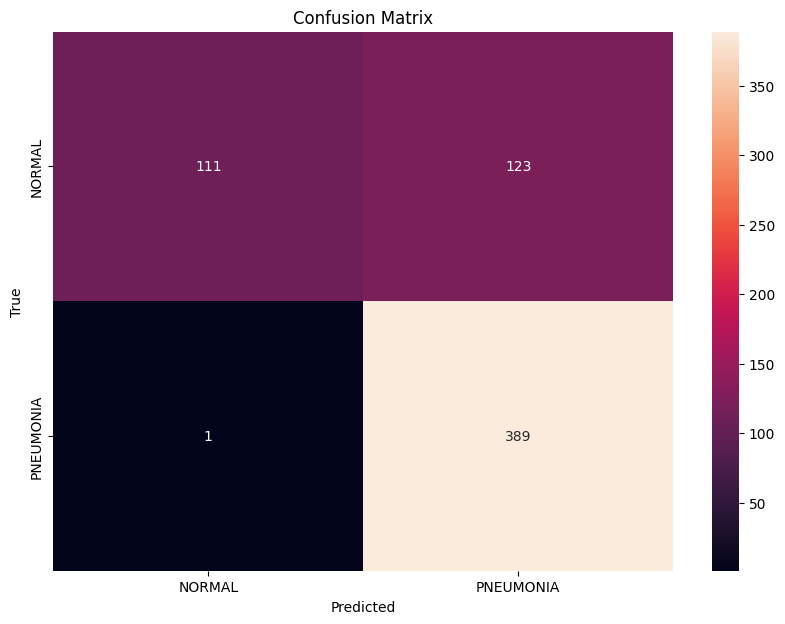

In [ ]:
# Eval test data with confusion Matrix
plot_confusion_matrix(all_labels, all_preds, class_names)



---



**Task 1b - Classification healthy, bacterial and viral Xray Imaging  🌵**


# Task 1.b - Classification of healthy/bacterial pneumonia/viral pneumonia

## Revision For 3 classes - Modifiy Dataloader and Model Architecture

In [8]:
# Model architecture (pretrain from 1a)
class ResNet3Classes(nn.Module):
    def __init__(self, pretrained_model):
        super(ResNet3Classes, self).__init__()
        self.pretrained = pretrained_model
        # Remove the last layer (classifier) to get the embeddings
        self.features = nn.Sequential(*list(pretrained_model.children())[:-1])
        self.fc = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 3)).to(device)


    def forward(self, x):
        x = self.features(x)
        x = x.view(-1,512)
        x = self.fc(x)  # Flatten the features
        return x

In [9]:
# Define New Dataloader for 3 classes, add one more label: "Normal" - label 0, "Virus" - label 1, for "bacteria": label 2
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []

        # Loop through each folder and file, assigning labels based on the criteria
        for subdir, dirs, files in os.walk(root_dir):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.images.append(os.path.join(subdir, file))
                    if 'NORMAL' in subdir:
                        self.labels.append(0)  # Normal
                    elif 'virus' in file.lower():
                        self.labels.append(1)  # Virus
                    elif 'bacteria' in file.lower():
                        self.labels.append(2)  # Bacteria

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label

In [10]:
data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Grayscale(num_output_channels=3),  # Add this line if you need to convert grayscale to RGB
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [11]:
image_datasets = {
    TRAIN: CustomDataset(os.path.join(data_dir, TRAIN), transform=data_transform),
    VAL: CustomDataset(os.path.join(data_dir, VAL), transform=data_transform),
    TEST: CustomDataset(os.path.join(data_dir, TEST), transform=data_transform)
}

dataloaders = {
    TRAIN: torch.utils.data.DataLoader(image_datasets[TRAIN], batch_size=64, shuffle=True),
    VAL: torch.utils.data.DataLoader(image_datasets[VAL], batch_size=1, shuffle=True),
    TEST: torch.utils.data.DataLoader(image_datasets[TEST], batch_size=1, shuffle=True)
}

dataset_sizes = {
    x: len(image_datasets[x])
    for x in [TRAIN, VAL]
}

## ResNet Testing 3 classes

In [37]:
checkpoint_winning = checkpoint_dir + "/winning architecture/epoch_10_winning_1b.pth"

model_pre = models.resnet18(pretrained=True)
model_pre.fc = nn.Sequential(
    nn.Linear(512, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 2)).to(device)
model_pre = ResNet3Classes(model_pre)
checkpoint = torch.load(checkpoint_winning, map_location=torch.device(device))
model_pre.load_state_dict(checkpoint)
for param in model_pre.parameters():
    param.requires_grad = False
model_pre.eval()
model_pre = model_pre.to(device)

In [38]:
true_labels, pred_labels, input_images, running_correct, running_total, acc, all_labels, all_preds = test_model()


In [39]:
print("Test Accuracy: ", acc)


Test Accuracy:  0.7355769230769231


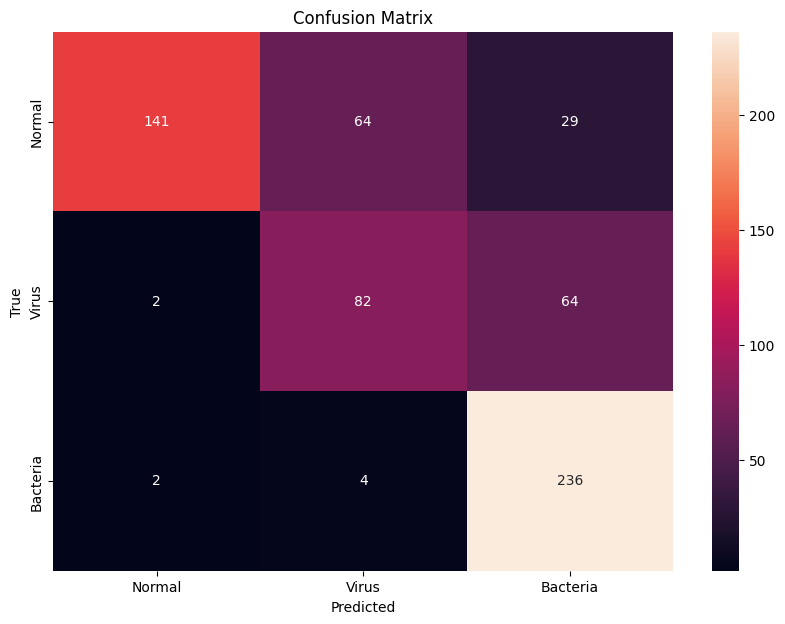

In [40]:
# Eval test data with confusion Matrix
plot_confusion_matrix(all_labels, all_preds, ["Normal", "Virus", "Bacteria"])

## AlexNet Testing 3 classes

In [41]:
checkpoint_winning = checkpoint_dir + "/winning architecture/AlexNet3 classes.pth"

model_pre = models.alexnet(pretrained=True)

# Freeze the pre-trained parameters
for param in model_pre.parameters():
    param.requires_grad = False

# Replace the classifier (fully connected layers) with a custom one
model_pre.classifier = nn.Sequential(
    nn.Linear(256 * 6 * 6, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 1024),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(1024, 3)  # Output layer for 2 classes (adjust based on your task)
).to(device)


checkpoint = torch.load(checkpoint_winning,map_location=torch.device(device))
model_pre.load_state_dict(checkpoint)
model_pre.eval()
model_pre = model_pre.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 95.4MB/s]


In [42]:
true_labels, pred_labels, input_images, running_correct, running_total, acc, all_labels, all_preds = test_model()

In [43]:
print("Test AlexNet with 3 classes accuracy: ", acc)

Test AlexNet with 3 classes accuracy:  0.6955128205128205


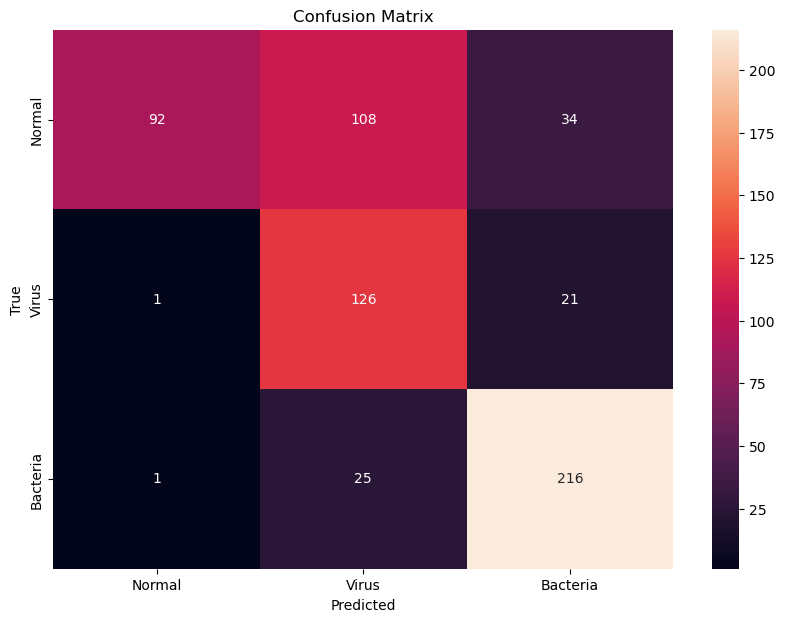

In [ ]:
# Eval test data with confusion Matrix
plot_confusion_matrix(all_labels, all_preds, ["Normal", "Virus", "Bacteria"])

## VGG16 Testing 3 classes

In [44]:
checkpoint_winning = checkpoint_dir + "/winning architecture/VGG16_3classes.pth"

model_pre = models.vgg16(pretrained=True)

# Freeze the pre-trained parameters
for param in model_pre.parameters():
    param.requires_grad = False

# Replace the classifier (fully connected layers) with a custom one
num_features = model_pre.classifier[6].in_features
model_pre.classifier[6] = nn.Sequential(
    nn.Linear(num_features, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 1024),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(1024, 3)  # Output layer for 2 classes (adjust based on your task)
)


checkpoint = torch.load(checkpoint_winning,map_location=torch.device(device))
model_pre.load_state_dict(checkpoint)
model_pre.eval()
model_pre = model_pre.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 77.9MB/s]


In [45]:
true_labels, pred_labels, input_images, running_correct, running_total, acc, all_labels, all_preds = test_model()

In [46]:
print("Test VGG16 with 3 classes accuracy: ", acc)

Test VGG16 with 3 classes accuracy:  0.7836538461538461


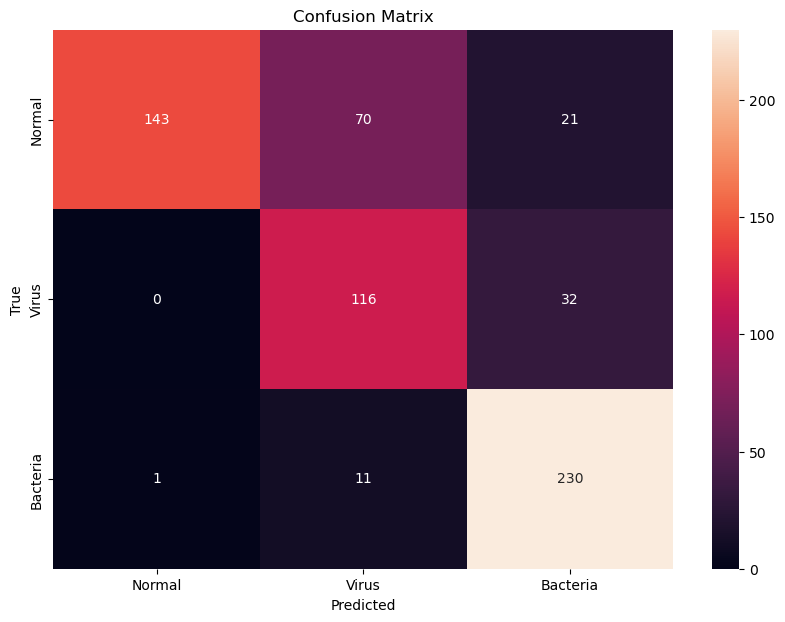

In [ ]:
# Eval test data with confusion Matrix
plot_confusion_matrix(all_labels, all_preds, ["Normal", "Virus", "Bacteria"])

# Task 2 - Tsne Visualization for 1.a

In [12]:
# Imports
import os
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import torch

In [52]:
train_embeddings_path = checkpoint_dir + "/winning architecture/train_embeddings.csv"
train_labels_path = checkpoint_dir + "/winning architecture/train_labels.csv"

train_embeddings = np.loadtxt(train_embeddings_path, delimiter=',')
train_labels = np.loadtxt(train_labels_path, delimiter=',')

In [53]:
test_embeddings_path = checkpoint_dir + "/winning architecture/test_embeddings.csv"
test_labels_path = checkpoint_dir + "/winning architecture/test_labels.csv"

test_embeddings = np.loadtxt(test_embeddings_path, delimiter=',')
test_labels = np.loadtxt(test_labels_path, delimiter=',')

In [54]:
# Apply KNN for classifier test data
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train_embeddings, train_labels)
knn_predictions = knn.predict(test_embeddings)

In [55]:
all_embeddings = np.vstack((train_embeddings, test_embeddings))
all_labels = np.concatenate((train_labels, np.full(train_labels.shape, -1), test_labels))  # -1 for train labels to differentiate
all_predictions = np.concatenate((np.full(train_labels.shape, -1), knn_predictions))  # -1 where train data, as we're focusing on test predictions

# Apply Tsne on test data
tsne_embeddings = TSNE(n_components=2, random_state=0).fit_transform(all_embeddings)



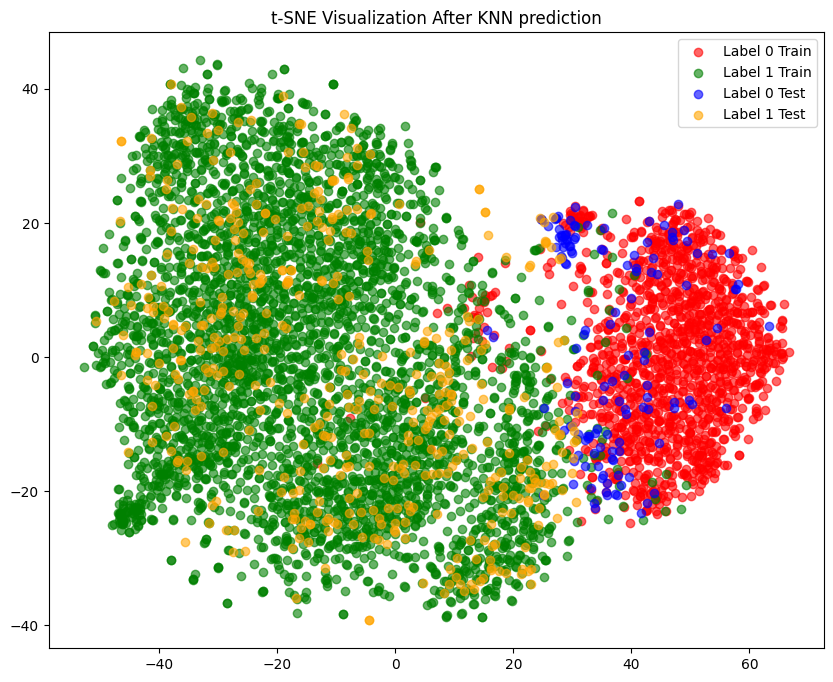

In [56]:
# Visualization of combined latent space: train and test samples
plt.figure(figsize=(10, 8))
all_labels_combined = np.concatenate((train_labels, knn_predictions + 2))  # Adding 2 to test labels to distinguish them

colors = ['red', 'green', 'blue', 'orange']

# Iterate through each label and plot
for label, color in zip(range(4), colors):
    indices = np.where(all_labels_combined == label)[0]
    plt.scatter(tsne_embeddings[indices, 0], tsne_embeddings[indices, 1], c=color, label=f"Label {label % 2} {'Test' if label >= 2 else 'Train'}", alpha=0.6)

plt.legend()
plt.title("t-SNE Visualization After KNN prediction")
plt.show()


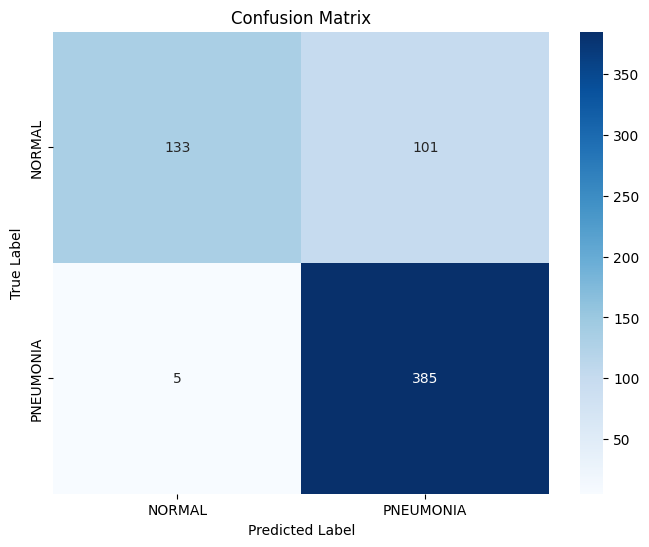

In [57]:
# Chacking KNN predictions
cm = confusion_matrix(test_labels, knn_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Task 2 - Tsne Visualization for 1.b

In [71]:
train_embeddings_path = checkpoint_dir + "/winning architecture/train_embeddings_3.csv"
train_labels_path = checkpoint_dir + "/winning architecture/train_labels_3.csv"

train_embeddings = np.loadtxt(train_embeddings_path, delimiter=',')
train_labels = np.loadtxt(train_labels_path, delimiter=',')

In [ ]:
# Aggergate test embedding
# We run this part in train notebook to save time

# test_embeddings, test_labels = generate_embeddings(dataloaders[TEST], embedding_model)

# test_embeddings_path = checkpoint_dir + "/winning architecture/test_embeddings_3.csv"
# test_labels_path = checkpoint_dir + "/winning architecture/test_labels_3.csv"

# # Save the embeddings and labels to a file
# np.savetxt(test_embeddings_path, test_embeddings, delimiter=',')
# np.savetxt(test_labels_path, test_labels, delimiter=',')

In [88]:
test_embeddings_path = checkpoint_dir + "/winning architecture/test_embeddings_3.csv"
test_labels_path = checkpoint_dir + "/winning architecture/test_labels_3.csv"

test_embeddings = np.loadtxt(test_embeddings_path, delimiter=',')
test_labels = np.loadtxt(test_labels_path, delimiter=',')

In [73]:
# Apply KNN for classifier test data
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train_embeddings, train_labels)
knn_predictions = knn.predict(test_embeddings)

In [74]:
all_embeddings = np.vstack((train_embeddings, test_embeddings))
all_labels = np.concatenate((train_labels, np.full(train_labels.shape, -1), test_labels))  # -1 for train labels to differentiate
all_predictions = np.concatenate((np.full(train_labels.shape, -1), knn_predictions))  # -1 where train data, as we're focusing on test predictions

# Apply Tsne on test data
tsne_embeddings = TSNE(n_components=2, random_state=0).fit_transform(all_embeddings)



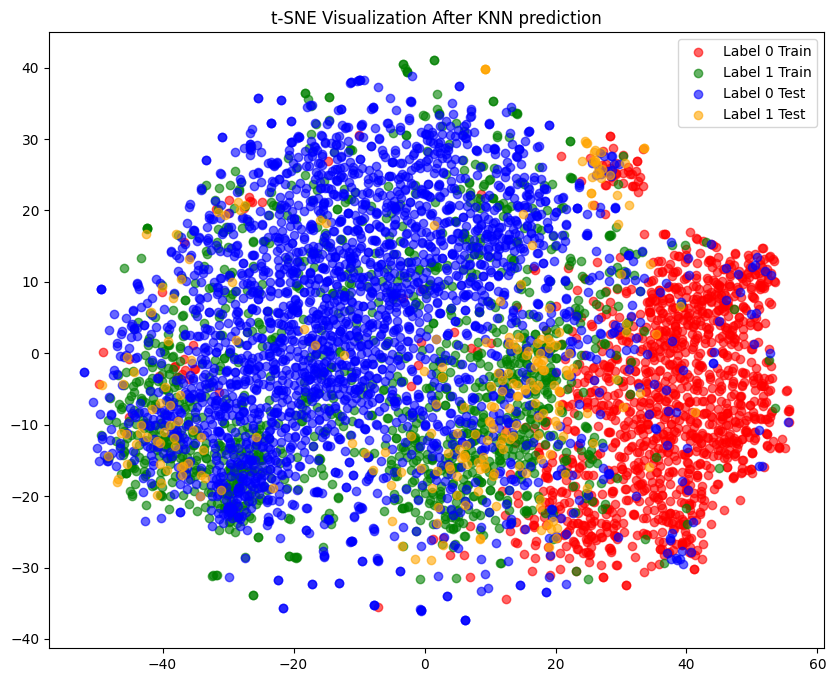

In [75]:
# Visualization of combined latent space: train and test samples
plt.figure(figsize=(10, 8))
all_labels_combined = np.concatenate((train_labels, knn_predictions + 2))  # Adding 2 to test labels to distinguish them

colors = ['red', 'green', 'blue', 'orange']

# Iterate through each label and plot
for label, color in zip(range(4), colors):
    indices = np.where(all_labels_combined == label)[0]
    plt.scatter(tsne_embeddings[indices, 0], tsne_embeddings[indices, 1], c=color, label=f"Label {label % 2} {'Test' if label >= 2 else 'Train'}", alpha=0.6)

plt.legend()
plt.title("t-SNE Visualization After KNN prediction")
plt.show()


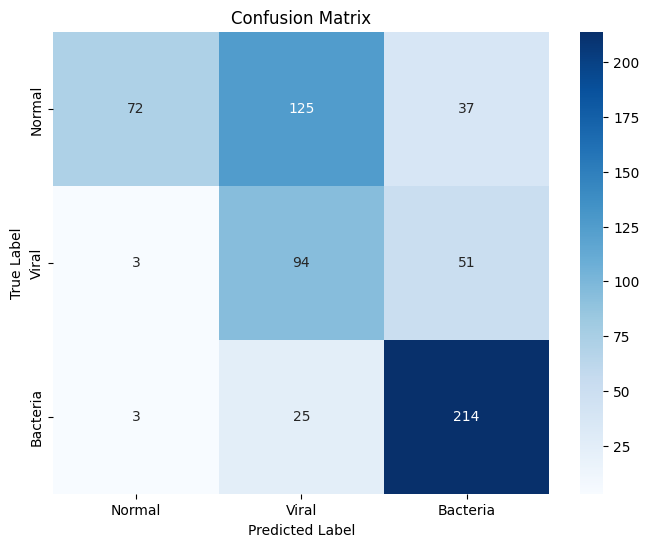

In [76]:
# Chacking KNN predictions
cm = confusion_matrix(test_labels, knn_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Task 3 - Anomaly Detection

### Autoencoder Model

In [78]:
import torch.nn as nn

class AE(nn.Module):
    def __init__(self, latent_size, multiplier=4, img_size=64):
        super(AE, self).__init__()
        out_channels = 1
        self.fm = img_size // 16
        self.mp = multiplier
        self.encoder = nn.Sequential(
            nn.Conv2d(1, int(16 * multiplier), 4, 2, 1, bias=False),
            nn.BatchNorm2d(int(16 * multiplier)),
            nn.ReLU(True),
            nn.Conv2d(int(16 * multiplier),
                      int(32 * multiplier), 4, 2, 1, bias=False),
            nn.BatchNorm2d(int(32 * multiplier)),
            nn.ReLU(True),
            nn.Conv2d(int(32 * multiplier),
                      int(64 * multiplier), 4, 2, 1, bias=False),
            nn.BatchNorm2d(int(64 * multiplier)),
            nn.ReLU(True),
            nn.Conv2d(int(64 * multiplier),
                      int(64 * multiplier), 4, 2, 1, bias=False),
            nn.BatchNorm2d(int(64 * multiplier)),
            nn.ReLU(True),
        )
        self.linear_enc = nn.Sequential(
            nn.Linear(int(64 * multiplier) * self.fm*self.fm, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(True),
            nn.Linear(2048, latent_size),
        )


        self.linear_dec = nn.Sequential(
            nn.Linear(latent_size, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(True),
            nn.Linear(2048, int(64 * multiplier) * self.fm*self.fm),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(int(64*multiplier), int(64 *
                                                       multiplier), 4, 2, 1, bias=False),
            nn.BatchNorm2d(int(64*multiplier)),
            nn.ReLU(True),
            nn.ConvTranspose2d(int(64*multiplier), int(32 *
                                                       multiplier), 4, 2, 1, bias=False),
            nn.BatchNorm2d(int(32*multiplier)),
            nn.ReLU(True),
            nn.ConvTranspose2d(int(32*multiplier), int(16 *
                                                       multiplier), 4, 2, 1, bias=False),
            nn.BatchNorm2d(int(16*multiplier)),
            nn.ReLU(True),
            nn.ConvTranspose2d(int(16*multiplier),
                               out_channels, 4, 2, 1, bias=False),
        )

    def forward(self, x):
        lat_rep = self.feature(x)
        out = self.decode(lat_rep)
        return out

    def feature(self, x):
        lat_rep = self.encoder(x)
        lat_rep = lat_rep.view(lat_rep.size(0), -1)
        lat_rep = self.linear_enc(lat_rep)
        return lat_rep

    def decode(self, x):
        out = self.linear_dec(x)
        out = out.view(out.size(0), int(64 * self.mp), self.fm, self.fm)
        out = self.decoder(out)
        return out


### Loading Data

In [79]:
import cv2
import os
import glob as gb
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset

BATCH_SIZE = 64
IMG_SIZE = 64
NORMAL = 'NORMAL'
BACTERIA = 'bacteria'
VIRAL = 'virus'
PNEUMONIA = 'PNEUMONIA'
code = {NORMAL:0 ,PNEUMONIA:1 }
X_test = []
y_test = []

test_path=data_dir + '/test/'
for folder in  os.listdir(test_path) :
    files = gb.glob(pathname= str( test_path + folder  + '/*.jpeg'))
    for file in files:
        # Read the image
        image = cv2.imread(file)
        # Convert the image to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Resize the grayscale image to 64x64 pixels
        resized_image = cv2.resize(gray_image, (64, 64))
        # Append the resized grayscale image to X_train
        X_test.append(resized_image)
        # Append the label to y_train
        y_test.append(code[folder])
np.save('X_test_gray',X_test)
np.save('y_test_gray',y_test)

# Load preprocessed data
X_test = np.load('X_test_gray.npy')
y_test = np.load('y_test_gray.npy')

# Convert data to PyTorch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


# Define dataset and dataloader
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

### Testing AE

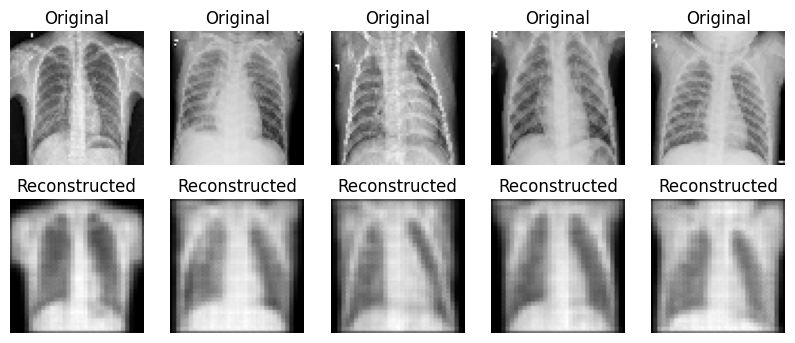

Error rate:0.29914529914529914
Precision:0.7959183673469388 Sensitivity:0.7 Specificity:0.7008547008547008 f1:0.7448840381991814



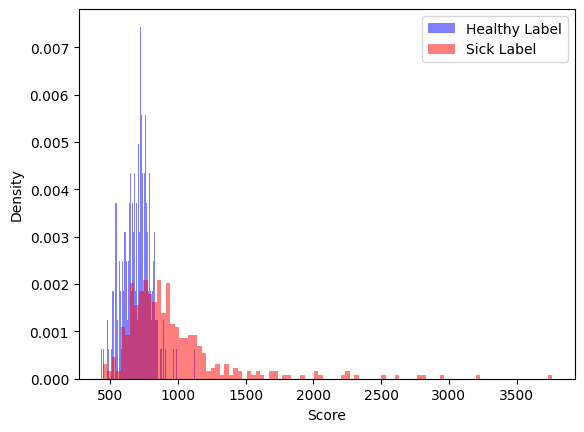

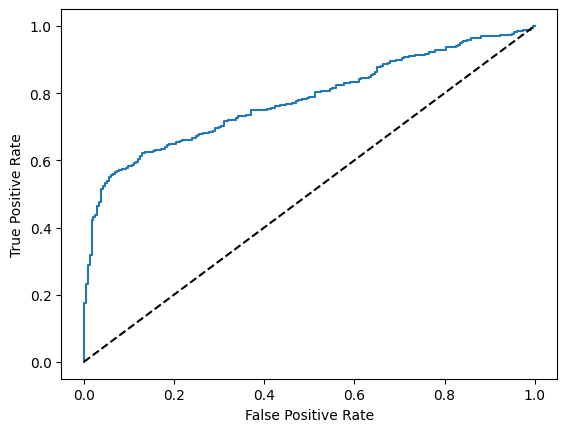

In [89]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import torch
from sklearn import metrics
def plotImages(out, x):
    out_np = out.detach().numpy()
    x_np = x.detach().numpy()

    # Plot original images
    plt.figure(figsize=(10, 4))
    for i in range(5):  # Plotting first 5 images as an example
        plt.subplot(2, 5, i + 1)
        plt.imshow(x_np[i].squeeze(), cmap='gray')
        plt.title("Original")
        plt.axis('off')

    # Plot reconstructed images
    for i in range(5):  # Plotting first 5 images as an example
        plt.subplot(2, 5, i + 6)
        plt.imshow(out_np[i].squeeze(), cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')

    plt.show()

def classify_anomalies(reconstruction_errors, threshold):
    predicted_labels = (reconstruction_errors > threshold).astype(int)
    return predicted_labels

def metrics_at_eer(y_score, y_true):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score)
    idx = None
    for i in range(len(fpr)):
        fnr = 1 - tpr[i]
        if abs(fpr[i] - fnr) <= 5e-3:
            idx = i
            break
    assert idx is not None

    t = thresholds[idx]
    y_pred = np.zeros_like(y_true)

    mean_error = np.mean(y_score)
    std_error = np.std(y_score)
    # threshold = mean_error + 2.0 * std_error
    # y_pred[y_score <threshold] = 0
    # y_pred[y_score >= threshold] = 1
    y_pred[y_score < t] = 0
    y_pred[y_score >= t] = 1
    pres = metrics.precision_score(y_true, y_pred)
    sens = metrics.recall_score(y_true, y_pred, pos_label=1)
    spec = metrics.recall_score(y_true, y_pred, pos_label=0)
    f1 = metrics.f1_score(y_true, y_pred)
    print('Error rate:{}'.format(fpr[idx]))
    print('Precision:{} Sensitivity:{} Specificity:{} f1:{}\n'.format(
        pres, sens, spec, f1))

def test_for_xray(model=None, loader=None):
    model.eval()
    flag = True
    with torch.no_grad():
        y_score, y_true = [], []
        for data in loader:
            x, label = data
            x.permute(0, 3, 1, 2)
            out = model(x)
            if flag:
                flag = False
                plotImages(out, x)
            rec_err = (out - x) ** 2
            res = rec_err
            res = res.mean(dim=(1,2,3))
            y_true.append(label)
            y_score.append(res.view(-1))

        y_true = np.concatenate(y_true)
        y_score = np.concatenate(y_score)
        metrics_at_eer(y_score, y_true)
        plt.figure()
        plt.hist(y_score[y_true == 0], bins=100, density=True, color='blue', alpha=0.5, label='Healthy Label')
        plt.hist(y_score[y_true == 1], bins=100, density=True, color='red', alpha=0.5, label='Sick Label')
        plt.xlabel('Score')
        plt.ylabel('Density')
        plt.legend()
        plt.figure()
        fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score)
        plt.plot(fpr, tpr)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()

model_path = checkpoint_dir + "/winning architecture/AE_gray.pth"
model = AE(latent_size=64)
model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
test_for_xray(model, test_loader)


# Task 4 - Explainability

In [103]:
# Imports
import torch
import os
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from matplotlib import pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
import random


In [95]:
# sample image code
def sample_images(dataset_path, n=5):
    all_images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(dataset_path) for f in filenames if os.path.splitext(f)[1].lower() in ['.png', '.jpg', '.jpeg']]
    sampled_images = random.sample(all_images, n)
    return sampled_images

In [96]:
# Dataloaders and Transforms
def load_image(image_path):
    """
    Loads an image from the specified path and applies the necessary transformations.

    Args:
    - image_path: Path to the image file.

    Returns:
    - transformed_image: The transformed image as a PyTorch tensor.
    """
    # Define the transformations: resize, center crop, to tensor, and normalize
    # These transformations should match the preprocessing used during model training
    transformation = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

    # Load the image
    image = Image.open(image_path).convert('RGB')

    # Apply the transformations
    transformed_image = transformation(image)

    # Add batch dimension (B, C, H, W) where B = 1
    transformed_image = transformed_image.unsqueeze(0)

    return transformed_image
# Data transformations
data_transforms = {
    TRAIN: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    VAL: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    TEST: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
}

# Load datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in [TRAIN, VAL, TEST]}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True)
               for x in [TRAIN, VAL]}
dataloaders[TEST] = torch.utils.data.DataLoader(image_datasets[TEST], batch_size=1, shuffle=False)

class_names = image_datasets[TRAIN].classes

In [98]:
# Occlusion Method
def generate_occlusion_heatmap(model, image, target_class, occlusion_size=32, occlusion_pixel=0.5, stride=8):
    """
    Generates an occlusion heatmap by occluding parts of the image and observing the effect on model prediction.

    Args:
    - model: The pre-trained model.
    - image: The input image as a PyTorch tensor.
    - target_class: The target class index for which the prediction is to be observed.
    - occlusion_size: The size of the square occlusion.
    - occlusion_pixel: The pixel value to use for occluded areas.
    - stride: The stride with which the occlusion window is moved across the image.

    Returns:
    - heatmap: A heatmap of prediction changes due to occlusion.
    """
    width, height = image.shape[2], image.shape[3]
    output_height = int(np.ceil((height - occlusion_size) / stride)) + 1
    output_width = int(np.ceil((width - occlusion_size) / stride)) + 1

    heatmap = torch.zeros((output_height, output_width))

    # Process each occlusion patch
    for h in range(0, height-occlusion_size+1, stride):
        for w in range(0, width-occlusion_size+1, stride):
            occluded_image = image.clone()
            occluded_image[:, :, h:h+occlusion_size, w:w+occlusion_size] = occlusion_pixel

            # Forward pass through the model
            output = model(occluded_image)
            probabilities = torch.nn.functional.softmax(output, dim=1)
            prob_target_class = probabilities[0][target_class].item()

            # Calculate the position in the heatmap
            heatmap_pos_h = min(int(np.floor(h / stride)), output_height-1)
            heatmap_pos_w = min(int(np.floor(w / stride)), output_width-1)

            heatmap[heatmap_pos_h, heatmap_pos_w] = prob_target_class

    return heatmap

In [105]:
# Initialize Model
checkpoint_dir_ResNet = checkpoint_dir + "/winning architecture/epoch_7_winning_1a.pth"
embedding_model = models.resnet18()
embedding_model.fc = nn.Sequential(
    nn.Linear(512, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 2)).to(device)
checkpoint = torch.load(checkpoint_dir_ResNet, map_location=torch.device(device))
embedding_model.load_state_dict(checkpoint)
embedding_model.to(device)
embedding_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [109]:
NORMAL = 'NORMAL'
PNEUMONIA = 'PNEUMONIA'
code = {NORMAL:0 ,PNEUMONIA:1 }


In [111]:
# Now, let's sample images and generate their occlusion heatmaps
sampled_images = sample_images(os.path.join(data_dir, 'train', PNEUMONIA), n=5)
heatmaps = []

for image_path in sampled_images:
    input_image = load_image(image_path).to(device)
    heatmap = generate_occlusion_heatmap(embedding_model, input_image, code[PNEUMONIA], occlusion_size=8, stride=8)
    heatmaps.append(heatmap)


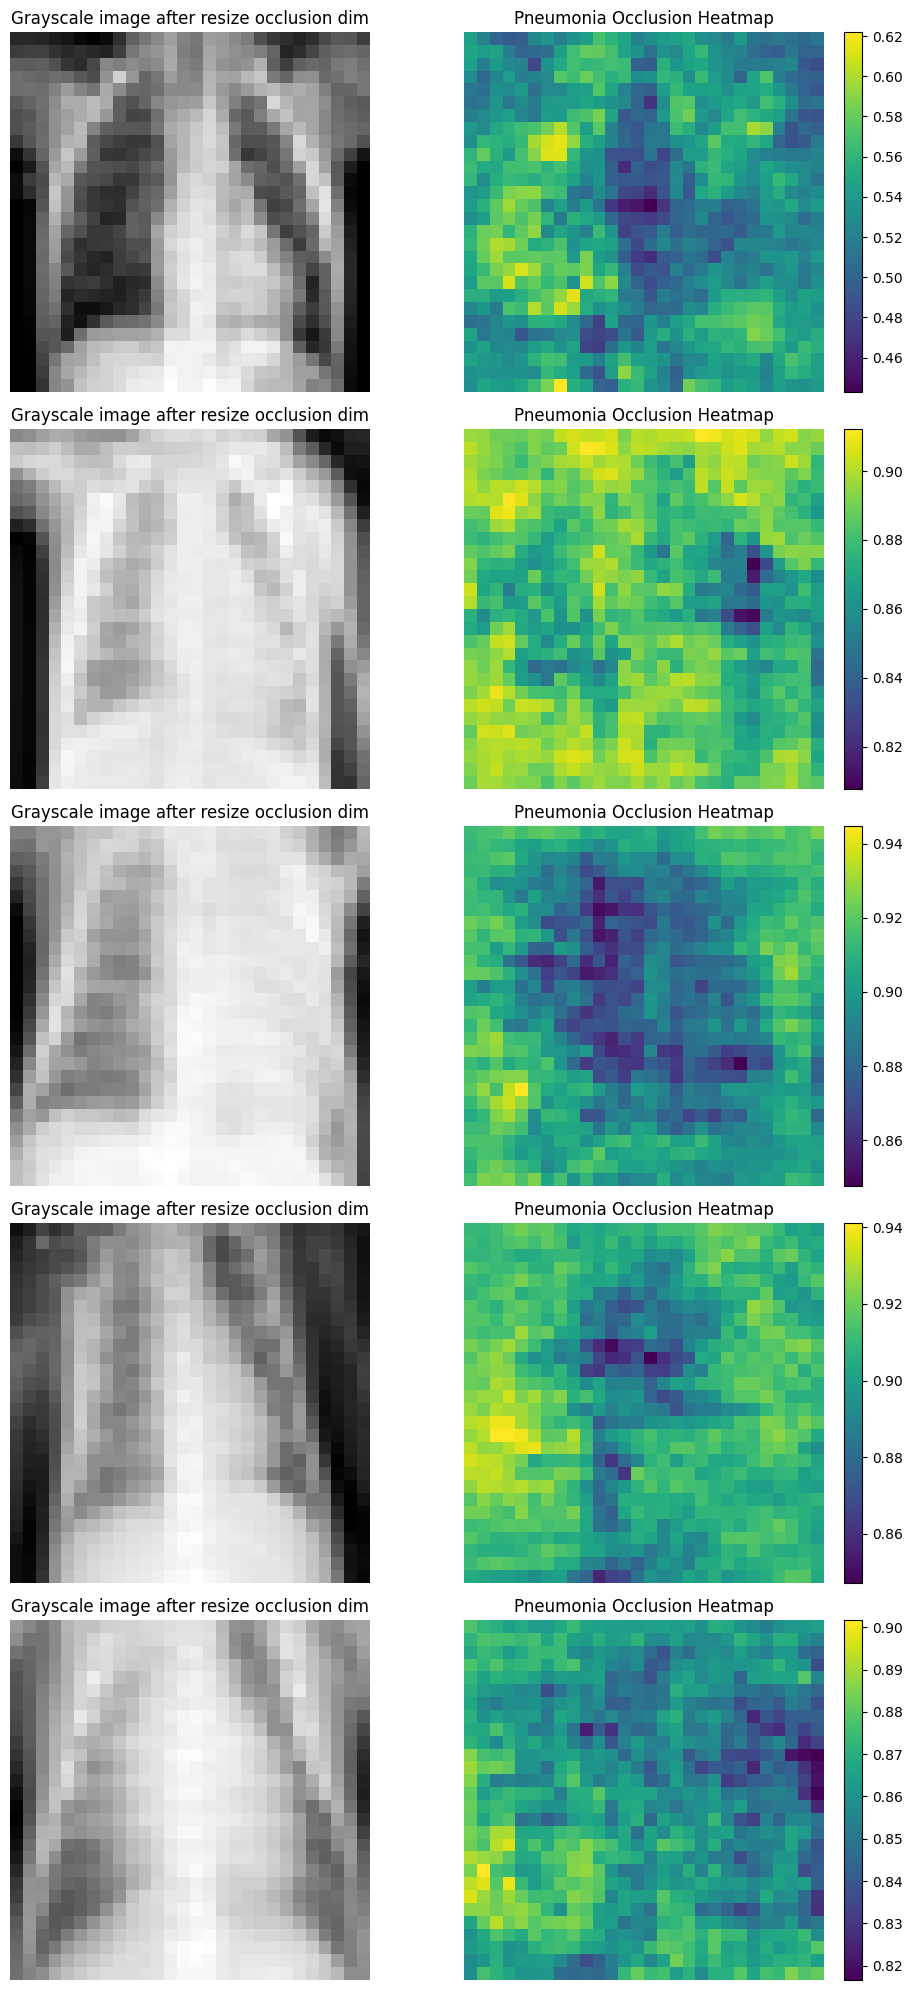

In [112]:
import cv2  # Import OpenCV for image resizing

# Plotting the images and their corresponding heatmaps
fig, axs = plt.subplots(5, 2, figsize=(10, 20))

for i, (image_path, heatmap) in enumerate(zip(sampled_images, heatmaps)):
    # Load the original image
    image = Image.open(image_path).convert('L')  # Convert to grayscale

    # Resize the original image to match the heatmap size
    heatmap_size = heatmap.shape
    image_resized = image.resize((heatmap_size[1], heatmap_size[0]), Image.BILINEAR)

    # Original grayscale image
    axs[i, 0].imshow(image_resized, cmap='gray')
    axs[i, 0].axis('off')
    axs[i, 0].set_title('Grayscale image after resize occlusion dim')

    # Heatmap
    heatmap_img = axs[i, 1].imshow(heatmap.cpu().numpy(), cmap='viridis', interpolation='nearest')
    axs[i, 1].axis('off')
    axs[i, 1].set_title('Pneumonia Occlusion Heatmap')

    # Adding a color bar for the heatmap
    fig.colorbar(heatmap_img, ax=axs[i, 1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


In [113]:
# Now, let's sample images and generate their occlusion heatmaps
normal_dir = os.path.join(data_dir, 'train', NORMAL)

sampled_images = sample_images(normal_dir, n=5)
heatmaps = []

# Assuming the model and transformation are already defined and loaded
for image_path in sampled_images:
    input_image = load_image(image_path).to(device)
    heatmap = generate_occlusion_heatmap(embedding_model, input_image, code[NORMAL], occlusion_size=8, stride=8)
    heatmaps.append(heatmap)


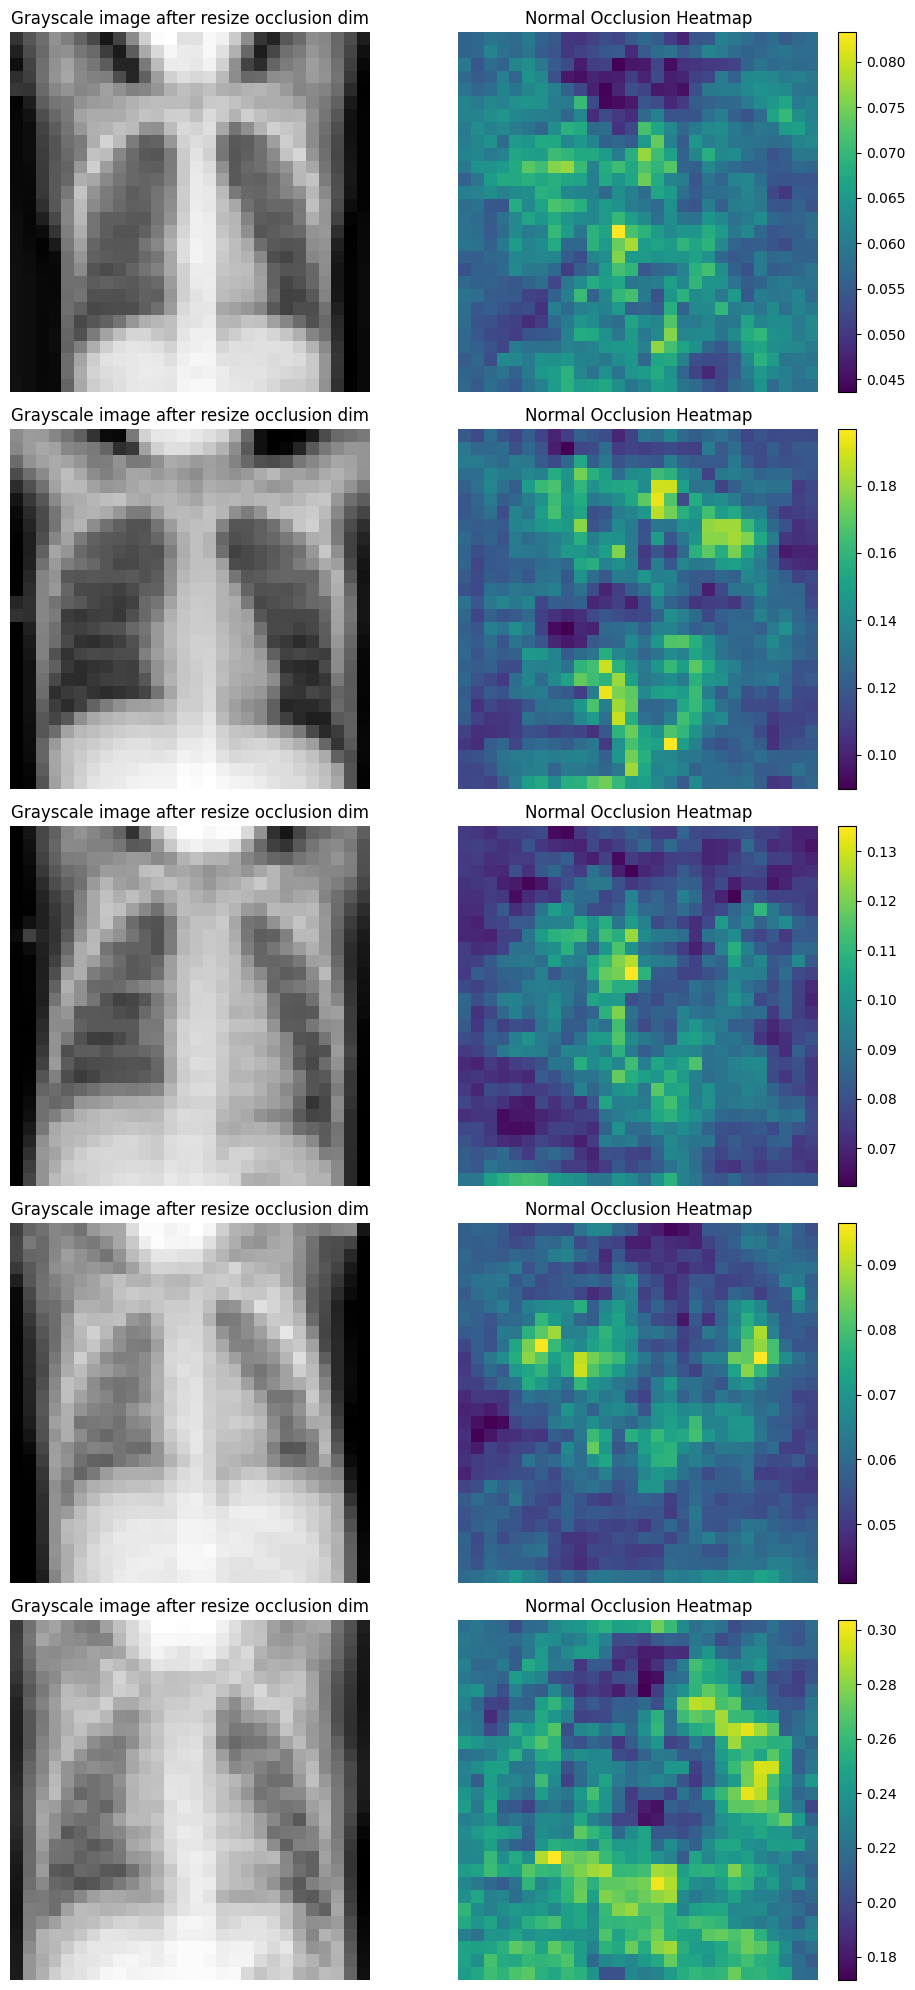

In [ ]:

# Plotting the images and their corresponding heatmaps
fig, axs = plt.subplots(5, 2, figsize=(10, 20))

for i, (image_path, heatmap) in enumerate(zip(sampled_images, heatmaps)):
    # Load the original image
    image = Image.open(image_path).convert('L')  # Convert to grayscale

    # Resize the original image to match the heatmap size
    heatmap_size = heatmap.shape
    image_resized = image.resize((heatmap_size[1], heatmap_size[0]), Image.BILINEAR)

    # Original grayscale image
    axs[i, 0].imshow(image_resized, cmap='gray')
    axs[i, 0].axis('off')
    axs[i, 0].set_title('Grayscale image after resize occlusion dim')

    # Heatmap
    heatmap_img = axs[i, 1].imshow(heatmap.cpu().numpy(), cmap='viridis', interpolation='nearest')
    axs[i, 1].axis('off')
    axs[i, 1].set_title('Normal Occlusion Heatmap')

    # Adding a color bar for the heatmap
    fig.colorbar(heatmap_img, ax=axs[i, 1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()